In [1]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1
def add_metadata(fname, d):
    match = re.search('width_mult_\d+', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = int(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
    match = re.search('seed_\d+', fname)
    if match:
        s = match.group(0)[len("seed_"):]
        d["seed"] = int(s)
    else:
        d["seed"] = None
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    match = re.search('parametr_', fname)
    if match:
        d['parametr'] = match.group(0)[len("parametr_"):]
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d
def get_data(folder_path, epoch=19):
    final_d = []
    for fp in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath)
            d = add_metadata(fp, d)
            d["name"] = fp
            final_d.append(d)
    return final_d
def loss_curves(run_ds, train=True, acc=True):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        # try:
        if train:
            loss_d["train_loss"] =  d["metrics"]["train_loss"]
            # loss_d["residual"] = d["metrics"]["residual"]
            # loss_d["top_eig_ggn"] = d["metrics"]["top_eig_ggn"]
            # d["metrics"]["directional_sharpness"].insert(0, float('nan'))

            if acc:
                if "train_acc" in d["metrics"].keys():
                    loss_d["train_acc"] =  d["metrics"]["train_acc"]
            if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
                loss_d["trace"] = d["metrics"]["trace"]
            if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
                loss_d["top_eig"] = d["metrics"]["top_eig"]
        else:
            loss_d["test_loss"] =  d["metrics"]["test_loss"]
            loss_d["test_acc"] =  d["metrics"]["test_acc"]
        loss_d["lr"] = d["lr"]
        loss_d["Learning Rate"] = d["lr"]
        loss_d["seed"] = d["seed"]
        loss_d["width_mult"] = d["width_mult"]
        loss_d["depth_mult"] = d["depth_mult"]
        # for eigi in range(10):
        loss_d[f"top_eig"] =  d["metrics"][f"top_eig"]
        loss_d["step"] = loss_d.index
        loss_d["beta"] = d["beta"]
        # loss_d["directional_sharpness"] = d["metrics"]["directional_sharpness"]
        loss_d["gamma_zero"] = d["gamma_zero"]
        loss_d["k_layers"] = d["k_layers"]
        loss_d["batch_size"] = d["batch_size"]
        ds.append(loss_d)
        # except KeyError:
        #     continue
    return pd.concat(ds, axis=0)
def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            l = [metric, 'seed', 'directional_sharpness', 'lr', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size']
            l.append(f'top_eig')
            d = {k: d[k] for k in l}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [2]:
sns.set(style="whitegrid", font_scale=2.0, palette=sns.color_palette("rocket", n_colors=5))
plt.figure(figsize = (10,6))
folder_path = "/home/ameterez/work/nips2024/vit_training_with_lr_scaling"
metric = "train_loss"
run_ds = get_data(folder_path, epoch=19)
df = loss_curves(run_ds, acc=False).reset_index()
df = df[df['lr'] < 2e-3]
lrs = sorted(df.lr.unique())
print(lrs)

[0.0001, 0.000167, 0.000278, 0.000464, 0.000774, 0.001292]


<Figure size 1000x600 with 0 Axes>

/tmp/ipykernel_2173958/3425522408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Depth'] = df2['depth_mult'] * 6


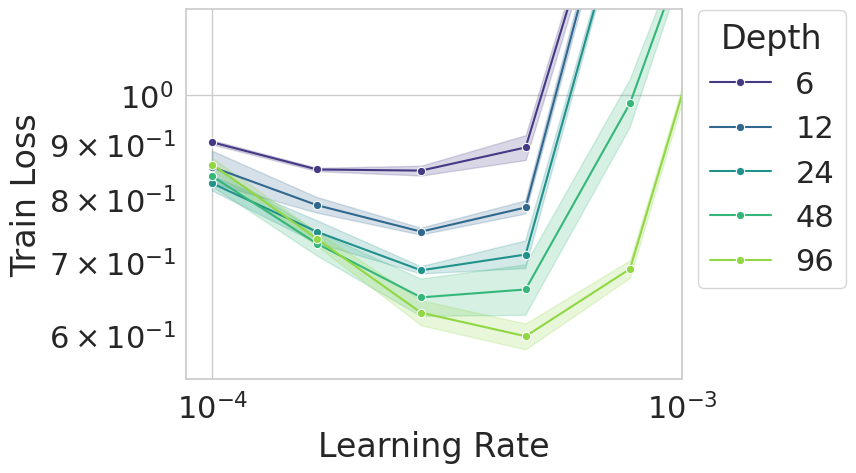

In [3]:
palette=sns.color_palette("viridis", n_colors=5)
df2 = df[df['step'] == df['step'].max()]
df2['Depth'] = df2['depth_mult'] * 6
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='lr', y='train_loss', hue='Depth', ax=ax, marker='o', palette=palette)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1.04))
ax.set_ylabel('Train Loss')
ax.set_xlabel('Learning Rate')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(top=1.2)
ax.set_xlim(right=1e-3)
fig.savefig('vit_with_lr_scaling_cifar10_transfer.pdf', bbox_inches='tight')
fig.show()

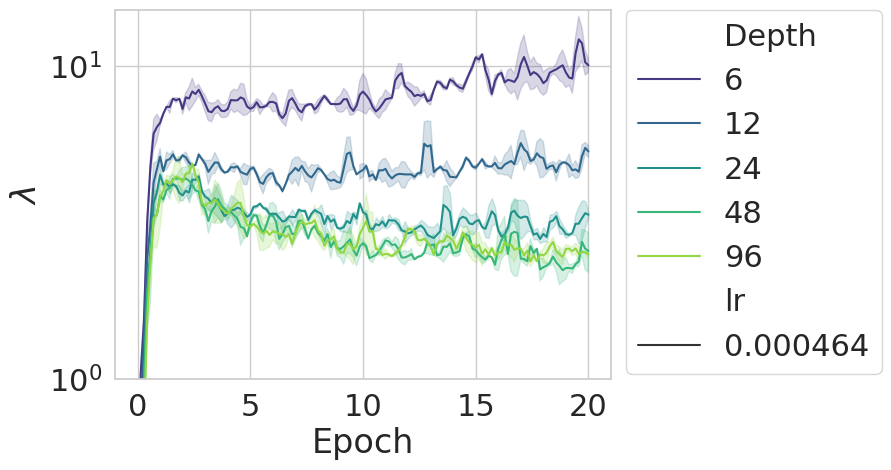

In [4]:
palette=sns.color_palette("viridis", n_colors=5)

df2 = df[df['lr'].isin([lrs[3]])]
df2 = df2[df2['top_eig'] > 0]
df2['Depth'] = df2['depth_mult'] * 6
df2['Epoch'] = (df2['step'] / df2['step'].max())*20
df2['top_eig'] /= np.sqrt(df2['Depth'])
df2['top_eig'] *= (df2['width_mult'] * 64)
df2['top_eig'] = df2.groupby(['seed', 'Depth'])['top_eig'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())


fig, ax = plt.subplots(ncols=1, nrows=1)
sns.lineplot(df2, x='Epoch', y='top_eig', style='lr', hue='Depth', ax=ax, palette=palette)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1.04))
ax.set_ylabel('$\lambda$')
# ax.set_xscale('log')
ax.set_ylim(bottom=1)
ax.set_yscale('log')
fig.savefig('vit_with_lr_scaling_cifar10_sharpness.pdf', bbox_inches='tight')
fig.show()